In [28]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd
import time
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use("fivethirtyeight")

In [29]:
def sample_ttc_data(units=15, exog=True):
    apts = list(range(1700, 1700+units))
    if exog:
        data={apts[i]:[i+1, list(np.random.choice(np.arange(1, units+1), units, replace=False))] for i in range(units)}
    else:
        data = {}
        p1, p2, p3, others = .5, .2, .1, .2/(units-3)
        for i in range(len(apts)):
            p = []
            for j in range(len(apts)):
                if j==i:
                    p.append(p1)
                elif abs(i - j)==1:
                    p.append(p2)
                elif abs(i-j)==2:
                    p.append(p3)
                else:
                    p.append(others)
            p = np.array(p)/sum(p)
            data[apts[i]] = [i+1, list(np.random.choice(np.arange(1, units+1), units, replace=False, p=p))]
    return data

In [30]:
def ttc(dic):
    #lists for accumulating outcomes
    matches = []
    matched = []
    assigned = []
    tie_breaks = 0 #checking for use of tie_breaker code block
    #function definitions
    #a function that takes in the latest preferences dictionary and returns edges for a directed graph
    def edges(dic):
        top_prefs = []
        for apt in dic: #for each apt, find what apartment has their top pref as its current assignment 
            best = dic[apt][1][0]
            for other in dic:
                if dic[other][0]==best:
                    match=other
                    top_prefs.append((apt, match))
                else:
                    pass
        return(top_prefs) #return a list of tuples (i, j), where j has i's most preferred assignment
    def cycles(dic):
        #create a graph object from which to identify a list of cycles or lack thereof
        G = nx.DiGraph() 
        G.add_edges_from(edges(dic))
        cycles = list(nx.simple_cycles(G))
        
        for cycle in cycles:
            first = cycle[0]
            for apt in cycle:
                #if the apartment is the last in the cycle, they get the first's spot
                if cycle.index(apt)==(len(cycle)-1): 
                    matches.append((apt, first))
                    matched.append(apt)
                    assigned.append(dic[first][0])
                else: #otherwise, people just get whose after them
                    next_apt = cycle[cycle.index(apt)+1]
                    matches.append((apt, next_apt))
                    matched.append(apt)
                    assigned.append(dic[next_apt][0])
        dic = {key:value for (key, value) in dic.items() if ((key not in matched)|(value[0] not in assigned))}
        for apt in dic: #update each apartment's preference list to remove any spots that were just assigned
            dic[apt][1] = [pref for pref in dic[apt][1] if pref not in assigned]
        return(dic) #return the latest dic
    
    while len(dic)>0:
        dic = cycles(dic)
    apts = []
    assignments = []
    for i, j in zip(matched, assigned):
        apts.append(i)
        assignments.append(j)
    final_aloc = pd.DataFrame({assignment: apt for assignment, apt in zip(apts, assignments)}, index=['Allocation'])
    final_aloc = final_aloc.loc[:, list(range(np.min(final_aloc.columns), np.max(final_aloc.columns)+1))]
    return final_aloc

### Checking Pareto Efficiency

#### Re-Running TTC

In [32]:
initial_data = sample_ttc_data(units=15, exog=True)
data_after_aloc = copy.deepcopy(initial_data)
alocs = ttc(initial_data) #first TTC
for apt in data_after_aloc:
    data_after_aloc[apt][0] = alocs[apt].values[0] #allocating according to first TTC
re_alocs = ttc(data_after_aloc) #second TTC

In [33]:
#first TTC results
alocs

,1700,1701,1702,1703,1704,1705,1706,1707,1708,1709,1710,1711,1712,1713,1714
Allocation,10,7,5,13,2,4,9,8,3,12,11,1,6,14,15


In [34]:
#second TTC results
re_alocs

,1700,1701,1702,1703,1704,1705,1706,1707,1708,1709,1710,1711,1712,1713,1714
Allocation,10,7,5,13,2,4,9,8,3,12,11,1,6,14,15


In [35]:
#difference
alocs-re_alocs

,1700,1701,1702,1703,1704,1705,1706,1707,1708,1709,1710,1711,1712,1713,1714
Allocation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Re-Running TTC Across 2,000 Simulated Preference Scenarios

In [36]:
any_changes = [None]*2000
for i in range(2000):
    initial_data = sample_ttc_data(units=15, exog=True)
    data_after_aloc = copy.deepcopy(initial_data)
    alocs = ttc(initial_data)
    for apt in data_after_aloc:
        data_after_aloc[apt][0] = alocs[apt].values[0]
    re_alocs = ttc(data_after_aloc)
    diff = alocs-re_alocs
    any_changes[i] = np.any(diff.iloc[0, :]!=0)
if ~np.any(any_changes):
    print(f'None of the {len(any_changes)} re-allocations following TTC resulted in any changes.')

None of the 2000 re-allocations following TTC resulted in any changes.


### Optimality Results

In [18]:
average_ut_boost_endog = [None]*2000
any_negatives_endog = [None]*2000
#code to run TTC 2000 times and record improved efficiency
for i in range(2000): 
    existing_situation = sample_ttc_data(units=15, exog=False) #record an initial state
    init_ut = []
    final_ut = []
    for apt in existing_situation: #for each apartment in that initial state, 
        #record what order their current assignment is in in their true preferences
        init_ut.append(15 - existing_situation[apt][1].index(existing_situation[apt][0]))
    #then run TTC to allocate
    final = ttc(existing_situation)
    for apt in list(final.columns): #for each column/apt, record its final allocation and the utility from it
        final_aloc = final[apt].values[0]
        final_ut.append(15 - existing_situation[apt][1].index(final_aloc))
    #record the average difference per apartment
    ut_imp = np.array(final_ut) - np.array(init_ut)
    any_negatives_endog[i] = int(np.any(ut_imp < 0))
    average_ut_boost_endog[i] = np.mean(ut_imp)

average_ut_boost_exog = [None]*2000
any_negatives_exog = [None]*2000
#code to run TTC 2000 times and record improved efficiency
for i in range(2000): 
    existing_situation = sample_ttc_data(units=15, exog=True) #record an initial state
    init_ut = []
    final_ut = []
    for apt in existing_situation: #for each apartment in that initial state, 
        #record what order their current assignment is in in their true preferences
        init_ut.append(15 - existing_situation[apt][1].index(existing_situation[apt][0]))
    #then run TTC to allocate
    final = ttc(existing_situation)
    for apt in list(final.columns): #for each column/apt, record its final allocation and the utility from it
        final_aloc = final[apt].values[0]
        final_ut.append(15 - existing_situation[apt][1].index(final_aloc))
    #record the average difference per apartment
    ut_imp = np.array(final_ut) - np.array(init_ut)
    any_negatives_exog[i] = int(np.any(ut_imp < 0))
    average_ut_boost_exog[i] = np.mean(ut_imp)

In [19]:
if sum(any_negatives_exog)==0 and sum(any_negatives_endog)==0:
    print('No one would be made worse off.')
else:
    print('Uh-oh.')
exog_boost = round(np.mean(average_ut_boost_exog), 2)
endog_boost = round(np.mean(average_ut_boost_endog), 2)
print(f'The mean average utility boost from states of exogeneous assignment is {exog_boost}.')
print(f'The mean average utility boost from states of endogeneous assignment is {endog_boost}.')

No one would be made worse off.
The mean average utility boost from states of exogeneous assignment is 7.04.
The mean average utility boost from states of endogeneous assignment is 1.17.


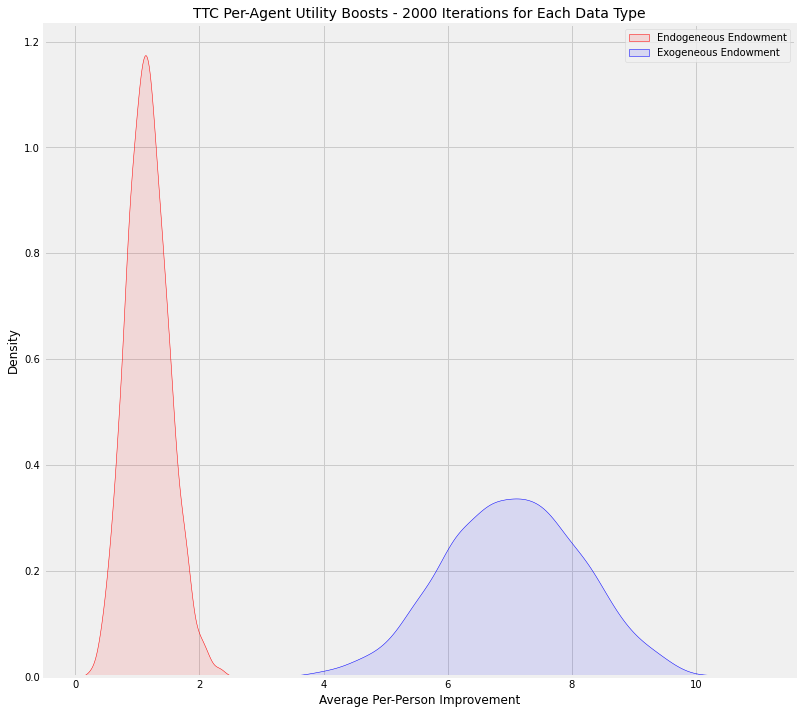

In [26]:
fig, ax = plt.subplots(1,1, figsize=(12,12))
sns.kdeplot(average_ut_boost_endog, shade=True, label='Endogeneous Endowment', color='red', alpha=0.1)
sns.kdeplot(average_ut_boost_exog, shade=True, label='Exogeneous Endowment', color='blue', alpha=0.1)
ax.set_title('TTC Per-Agent Utility Boosts - 2000 Iterations for Each Data Type', fontsize=14)
ax.set_xlabel('Average Per-Person Improvement')
ax.legend();

### Run Times

In [4]:
unit_counts = [i*5 for i in range(1, 21)] #evaluating run-time for 5 through 100 units

#case where pre-existing allocation is exogeneous 
run_times1 = []
for unit_count in unit_counts:
    run_times = [None]*10
    for j in range(10): #collect the run times of 10 uses of the algorithm for each unit count
        start = time.time()
        ttc(sample_ttc_data(units=unit_count, exog=True))
        end = time.time()
        ms = (end-start)*(10**3)
        run_times[j] = ms
    run_times1.append(np.mean(run_times)) #and record the mean number of milliseconds for that unit count
run_time1_df = pd.DataFrame({'N': unit_counts, 'Average Run Time (Exog)': run_times1})

#case where pre-existing allocation is endogeneous -- a function of apartment
run_times2 = []
for unit_count in unit_counts:
    run_times = [None]*10
    for j in range(10):
        start = time.time()
        ttc(sample_ttc_data(units=unit_count, exog=False))
        end = time.time()
        ms = (end-start)*(10**3)
        run_times[j] = ms
    run_times2.append(np.mean(run_times))
run_time2_df = pd.DataFrame({'N': unit_counts, 'Average Run Time (Endog)': run_times2})

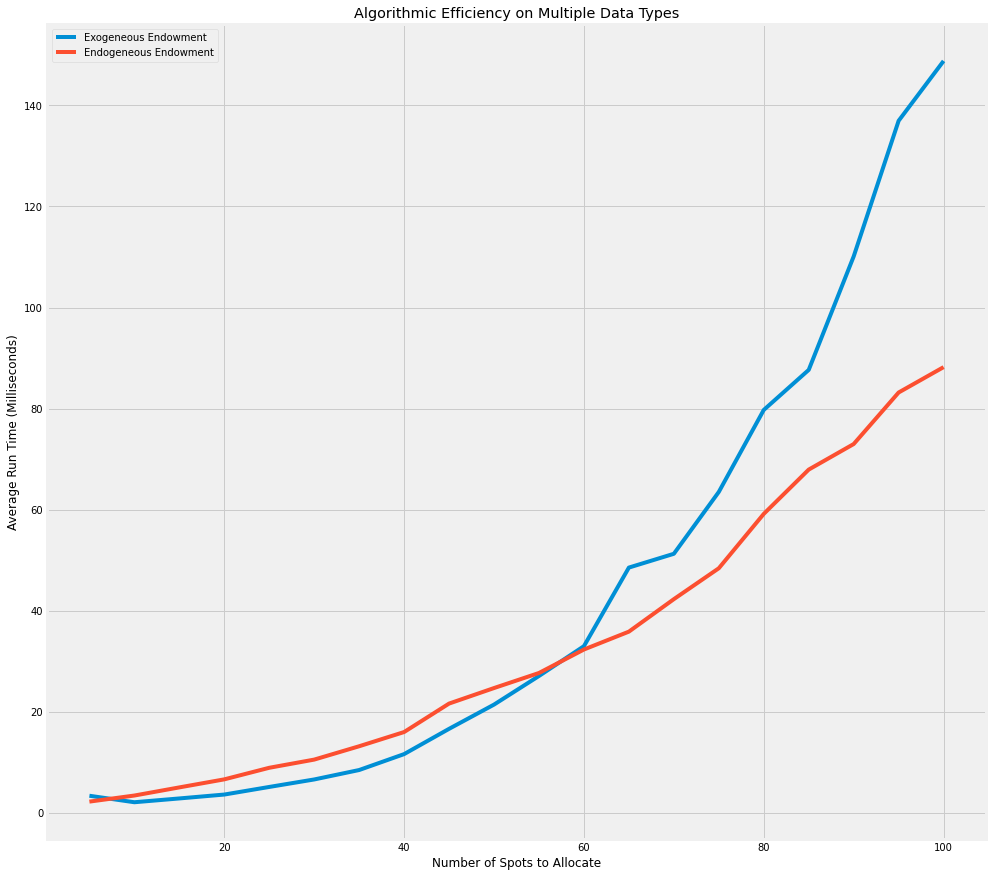

In [5]:
run_time = pd.merge(run_time1_df, run_time2_df, on='N')
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
sns.lineplot(data=run_time, x='N', y='Average Run Time (Exog)', label='Exogeneous Endowment')
sns.lineplot(data=run_time, x='N', y='Average Run Time (Endog)', label='Endogeneous Endowment')
ax.set_ylabel('Average Run Time (Milliseconds)')
ax.set_xlabel('Number of Spots to Allocate')
ax.set_title('Algorithmic Efficiency on Multiple Data Types');

### Ad Hoc Run Time Analysis

In [ ]:
[i*10 for i in range(1, 21)]

In [6]:
list(range(100, 1100, 100))

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

In [8]:
higher_unit_counts = list(range(100, 1100, 100))
run_times3 = []
for unit_count in higher_unit_counts:
    run_times = [None]*2
    for j in range(2):
        start = time.time()
        ttc(sample_ttc_data(units=unit_count, exog=False))
        end = time.time()
        ms = (end-start)*(10**3)
        run_times[j] = ms
    run_times3.append(np.mean(run_times))
run_time3_df = pd.DataFrame({'N': higher_unit_counts, 'Average Run Time (Endog)': run_times3})

In [12]:
run_time3_df['Average Run Time (Endog)'] = run_time3_df['Average Run Time (Endog)']/1000

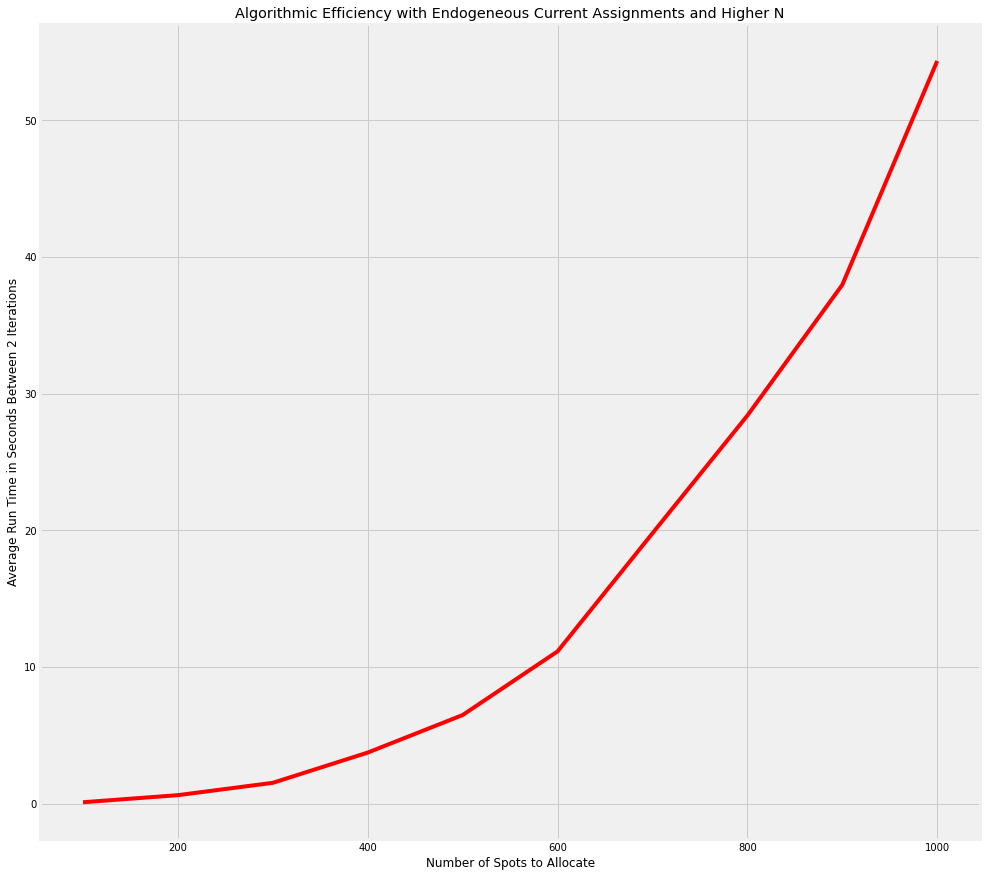

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
sns.lineplot(data=run_time3_df, x='N', y='Average Run Time (Endog)', color='red')
ax.set_ylabel('Average Run Time in Seconds Between 2 Iterations')
ax.set_xlabel('Number of Spots to Allocate')
ax.set_title('Algorithmic Efficiency with Endogeneous Current Assignments and Higher N');